# Modeling Demand for Cars with the IPDL model

In this notebook, we will explore the dataset used in
Goldberg & Verboven (2005). We will estimate the IPDL Model
model given the available data using the functions defined below.

In [375]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
import scipy.stats as scstat
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter
import numba as nb

# Files
import Logit_file as logit

Data
====

The dataset consists of approximately 110 vehicle makes per year in the period 1970-1999 in five european markets (Belgium, France, Germany, Italy, and the United Kingdom). Furthermore, the data contains information on various characteristics of the makes such as sales, prices, horse power, weight and other physical car characteristics. Also these characteristics may vary across markets. 

A observation in our analysis will be a market in a given year such that e.g. the French car market in 1995 counts as a single observation. If $Y = 30$ is the number of years, and $M = 5$ is the number of country-level markets, we thus have $T=Y\cdot M = 150$ markets and observations. In addition, since the available vehicle makes vary across time and place, let $\mathcal{J}_t$ denote the set of available makes in each market $t=1,\ldots,T$, and let $\mathcal{J} := \bigcup_{t=1}^T \mathcal{J}_t$ be the set of all makes which were available in some market. Then $J:=\#\mathcal{J}$ is the number of makes which were available at some point of time in the period in at least one country-level market. In our dataset there are $J = 356$ unique vehicle makes. Note also however that characteristics of vehicle makes vary across markets.

Our dataset includes 47 variables in total. The first three columns are market and product codes for the year, country, and make. Another variable is quantity sold (No. of new registrations) which will be used in computing observed market shares. The remaining 43 variables are potential explanatory variables. We will only consider the subset of these which describes car characteristics such as brand, after-tax price, horse power, etc. which adds up to $K=20$ characteristics. The remaining 23 variables are mainly macroeconomic variables such as e.g. GDP per capita which have been used to construct estimates of e.g. the average wage income and purchasing power. Since we are only interested in utility-shifting variables, we will not consider the latter columns. 

Reading in the dataset `eurocars.csv` we thus have a dataframe of $\sum_{t=1}^T \#\mathcal{J}_t = 11459$ rows and $47$ columns. The `ye` column runs through $y=70,\ldots,99$, the `ma` column runs through $m=1,\ldots,M$, and the ``co`` column takes values $j\in \mathcal{J}$. 

Because we consider a country-year pair as the level of observation, we construct a `market` column taking values $t=1,\ldots,T$. In python, this variable will take values $t=0,\ldots,T-1$. We also construct a `market_share` variable giving us the market share of any product $j$ in any market $t$; this will obviously take values in $[0,1]$. To deal with the fact that choice sets $\mathcal{J}_t$ vary across markets, we expand the dataframe so that every car $j\in \mathcal{J}$ which was observed in some market $t$ is in the choice set of all other markets as well, i.e. we impose $\mathcal{J}_t = \mathcal{J}$ for all markets $t$. We then impute a market share of $q_{jt}=0$ for any car $j$ which in reality was not available in market $t$. To this end we first construct an outside option $j=0$ in each market $t$  of not buying a car by letting the 'sales' of $j=0$ being determined as 

$$\mathrm{sales}_{0t} = \mathrm{pop}_t - \sum_{j=1}^J \mathrm{sales}_{jt}$$

where $\mathrm{pop}_t$ is the total population in market $t$.

We also read in the variable description of the dataset contained in `eurocars.dta`. We will use the list `x_vars` throughout to work with our explanatory variables.

Lastly, we access the underlying 3-dimensional numpy array of the explonatory variables `x` by sorting on `market` and then `co`, and subsequently resizing the explanatory variables as

> `x = dat[x_vars].values.resize((T,J,K))`

In [376]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
descr = (pd.read_stata('eurocars.dta', iterator = True)).variable_labels()
dat = pd.read_csv(os.path.join(input_path, 'eurocars.csv'))

In [377]:
pd.DataFrame(descr, index=['description']).transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,ye,year (=first dimension of panel)
1,ma,market (=second dimension of panel)
2,co,model code (=third dimension of panel)
3,zcode,alternative model code (predecessors and succe...
4,brd,brand code
5,type,name of brand and model
6,brand,name of brand
7,model,name of model
8,org,"origin code (demand side, country with which c..."
9,loc,"location code (production side, country where ..."


In [378]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11549 entries, 0 to 11548
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ye      11549 non-null  int64  
 1   ma      11549 non-null  int64  
 2   co      11549 non-null  int64  
 3   zcode   11549 non-null  int64  
 4   brd     11549 non-null  int64  
 5   type    11549 non-null  object 
 6   brand   11549 non-null  object 
 7   model   11521 non-null  object 
 8   org     11549 non-null  int64  
 9   loc     11549 non-null  int64  
 10  cla     11549 non-null  int64  
 11  home    11549 non-null  int64  
 12  frm     11549 non-null  int64  
 13  qu      11549 non-null  int64  
 14  cy      11549 non-null  object 
 15  hp      11549 non-null  object 
 16  we      11549 non-null  int64  
 17  pl      11549 non-null  object 
 18  do      11547 non-null  object 
 19  le      11549 non-null  object 
 20  wi      11549 non-null  object 
 21  he      11549 non-null  object 
 22

In [379]:
# Determine explanatory variables and find variable description as 'x_lab'
x_discretevars = ['home', 'brand'] # [ 'brand', 'home', 'cla']
x_contvars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac', 'pr']
x_orgvars =  [*x_contvars, *x_discretevars]

# Outisde is included if OO == True, and is not included else...
OO = True

# variable descriptions:
x_lab = (pd.DataFrame(descr, index=['description'])[x_orgvars].transpose().reset_index().rename(columns={'index' : 'variable names'}))
x_lab

,variable names,description
0,cy,cylinder volume or displacement (in cc)
1,hp,horsepower (in kW)
2,we,weight (in kg)
3,le,length (in cm)
4,wi,width (in cm)
5,he,height (in cm)
6,li,"average of li1, li2, li3 (used in papers)"
7,sp,maximum speed (km/hour)
8,ac,time to acceleration (in seconds from 0 to 100...
9,pr,price (in destination currency including V.A.T.)


We now clean the data to fit our setup

In [380]:
### First we create the 'market' column 

dat = dat.sort_values(by = ['ye', 'ma'], ascending = True)
Used_cols = [*dat.keys()[:28], 'pr', 'princ', 'pop', 'xexr', 'avexr'] 
dat = dat[Used_cols]
market_vals = [*iter.product(dat['ye'].unique(), dat['ma'].unique())]
market_vals = pd.DataFrame({'year' : [val[0] for val in market_vals], 'country' : [val[1] for val in market_vals]})
market_vals = market_vals.reset_index().rename(columns={'index' : 'market'})
dat = dat.merge(market_vals, left_on=['ye', 'ma'], right_on=['year', 'country'], how='left')
dat_org = dat # Save the original data with the 'market'-column added as 'dat_org'.


In [381]:
# We also create an inside/outside-option column if the outside option is included
if OO:
    dat['in_out'] = 1
else:
    None

#### We drop rows which contain NaN values in any explanatory variable or in the response variable.

In [382]:
dat = dat.dropna()

We also convert our discrete explanatory variables to integer valued variables and make sure our continuous variables are identified as floats.

In [383]:
obj_columns = dat.select_dtypes(['object'])
for col in obj_columns:
    if col in [*x_contvars, 'xexr', 'avexr']:
        dat[col] = dat[col].str.replace(',', '.').astype('float64')
    else:
        dat[col] = dat[col].astype('category').cat.rename_categories(np.arange(1, dat[col].nunique() + 1)).astype('int64')

C:\Users\mgq977\AppData\Local\Temp\ipykernel_2536\3139264709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[col] = dat[col].astype('category').cat.rename_categories(np.arange(1, dat[col].nunique() + 1)).astype('int64')
C:\Users\mgq977\AppData\Local\Temp\ipykernel_2536\3139264709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[col] = dat[col].astype('category').cat.rename_categories(np.arange(1, dat[col].nunique() + 1)).astype('int64')
C:\Users\mgq977\AppData\Local\Temp\ipykernel_2536\313926

In [384]:
# We reencode all variables such that only the outside option takes the value 0
x_0vars = [var for var in x_discretevars if len(dat[(dat['co'] != 0)&(dat[var].isin([0]))]) > 0]

for col in x_0vars:
    dat[col] = dat[col].astype('category').cat.rename_categories(np.arange(1, dat[col].nunique() + 1)).astype('int64')

C:\Users\mgq977\AppData\Local\Temp\ipykernel_2536\708423628.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[col] = dat[col].astype('category').cat.rename_categories(np.arange(1, dat[col].nunique() + 1)).astype('int64')


In [385]:
### Second we construct an outside option for each market t
if OO:
    outside_shares = dat.groupby('market', as_index=False)['qu'].sum()
    outside_shares = outside_shares.merge(dat[['market', 'pop']], on = 'market', how='left').dropna().drop_duplicates(subset = 'market', keep = 'first')
    outside_shares['qu'] = outside_shares['pop'] - outside_shares['qu']
    keys_add = [key for key in dat.keys() if (key!='market')&(key!='qu')&(key!='pop')]
    for key in keys_add:
        outside_shares[key] = 0

    dat = pd.concat([dat, outside_shares])
else:
    None

In [386]:
### Third we compute market shares for each product j in each market t 

dat['ms'] = dat.groupby('market')['qu'].transform(lambda x: x/x.sum())

In [387]:
# Find the amount of markets and amount of alternatives for each market
T = dat['market'].nunique()
J = np.array([dat[dat['market'] == t]['co'].nunique() for t in np.arange(T)])

# number of observations
if OO:
    N = np.array([dat[dat['market'] == t]['pop'].unique().sum() for t in np.arange(T)]).sum()
else:
    N = np.array([len(dat[dat['market'] == t]['co']) for t in np.arange(T)]).sum()

We also scale values such that they lie in the interval $[-1,1]$. This has various numerical benefits. Also, this will not affect elasticities or diversion ratios, but semielasticities will be affected by the scaling.  

In [388]:
dat[x_contvars] = dat[x_contvars] / dat[x_contvars].abs().max()

We encode the discete variables as onehot encoded variables:

In [389]:
dat_disc = pd.get_dummies(dat[x_discretevars], prefix = x_discretevars, columns=x_discretevars, drop_first=True) # Drop the outside option column when constructing dummies of discrete variables
dat_disc = dat_disc[[var for var in dat_disc.keys() if not var.endswith('1')]] # Drops a second column from discrete columns to identify parameters
x_disc_ohkeys = dat_disc.keys()
dat = pd.concat([dat, dat_disc], axis = 1)

if OO:
    x_vars = ['in_out', *x_contvars, *x_disc_ohkeys]
else:
    x_vars = [*x_contvars, *x_disc_ohkeys]

We find also the number of explanatory variables

In [390]:
K = len(x_vars)

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [391]:
# Create numpy arrays of response and explanatory variables
dat = dat.reset_index(drop = True).sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull

x = {t: dat[dat['market'] == t][x_vars].values.reshape((J[t],K)) for t in np.arange(T)}
y = {t: dat[dat['market'] == t]['ms'].to_numpy().reshape((J[t])) for t in np.arange(T)}

In [392]:
if OO:
    nest_vars = [var for var in ['in_out', *x_orgvars] if (var != 'pr')]
else:
    nest_vars = [var for var in x_orgvars if (var != 'pr')] # ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac']  we will nest on variables which are not price, brand, model.
nest_cont_vars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac']

G = len(nest_vars)

To check if our specififcation of the model is operational, we stack the design matrices $X_t$ of markets $t$ on top of each other to get the $\sum_t J_t$ by $K$ matrix $X^*$.

In [393]:
x_star = np.concatenate([x[t] for t in np.arange(T)], axis = 0)

In [394]:
pd.DataFrame(x_star)

XTX=x_star.T@x_star
[e,v]=la.eig(XTX)
print(e)


[4.18172094e+04 1.51194245e+03 8.33480907e+02 6.63621704e+02
 6.19596331e+02 5.73576387e+02 5.55397509e+02 5.05398845e+02
 4.24525878e+02 3.84850081e+02 3.00287423e+02 3.02063419e+02
 2.59006551e+02 2.45676682e+02 2.26642105e+02 2.16253594e+02
 1.96773303e+02 1.86193568e+02 1.77215039e+02 1.59428915e+02
 1.51168124e+02 1.08441640e+02 9.02903234e+01 7.80017834e+01
 6.10956434e+01 5.50035617e+01 5.17804496e+01 4.85116902e+01
 4.69232106e+01 4.48465462e+01 4.34297582e+01 3.49478996e+01
 2.78010403e+01 2.39853311e+01 1.55948562e+01 1.11374929e+01
 1.00237547e+01 6.43942208e+00 9.97646233e-01 1.52561673e+00
 4.21540233e+00 2.64853391e+00 2.99504916e+00 2.86137167e+00]


In [395]:
x_star[0:20,:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.89380531e-01, 3.48082596e-01, 5.49738220e-01,
        9.07114625e-01, 9.20212766e-01, 8.81987578e-01, 4.94444423e-01,
        6.31578947e-01, 2.70000000e-01, 1.28470526e-03, 0.00000

In [396]:
XTX.shape

(44, 44)

In [397]:
# Get each market's share of total population N
pop_share = np.empty((T,))
for t in np.arange(T):
    pop_share[t] = dat[dat['market'] == t]['qu'].sum() / N

#### Multinomial Logit - for comparison
Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

In [398]:
beta_0 = np.ones((K,))

# Estimate the model
res_logit = logit.estimate_logit(logit.q_logit, beta_0, y, x, sample_share=pop_share, Analytic_jac=True)

Optimization terminated successfully.
         Current function value: 0.001546
         Iterations: 24
         Function evaluations: 35
         Gradient evaluations: 35


In [399]:
logit_beta = res_logit['beta']
logit_score = logit.logit_score(logit_beta, y, x, pop_share) # maybe use 'logit.' functions from Logit_file instead of including e.g. standard errors in logit.estimate_logit function
logit_se = logit.logit_se(logit_score, N)
logit_t, logit_p = logit.logit_t_p(logit_beta, logit_score, N)
pd.DataFrame({'parameters': logit_beta, 'se' : logit_se, 't': logit_t, 'p': logit_p}, index = x_vars) # Our estimates

,parameters,se,t,p
in_out,-2.435520,0.000026,9.331757e+04,0.0
cy,-0.246269,0.000018,1.399485e+04,0.0
hp,-0.383298,0.000021,1.831138e+04,0.0
we,-0.857401,0.000016,5.347850e+04,0.0
le,-1.827391,0.000018,9.928522e+04,0.0
wi,-1.982906,0.000024,8.367728e+04,0.0
he,-1.995376,0.000024,8.380812e+04,0.0
li,-0.651964,0.000010,6.701176e+04,0.0
sp,-1.307546,0.000021,6.105287e+04,0.0
ac,-0.028687,0.000008,3.546958e+03,0.0


We then compute the corresponding Logit choice probabilities. STILL FIX THIS PART IN LOGIT BOOK!!!

In [400]:
logit_q = logit.logit_ccp(logit_beta, x)

We also find the elasticities and diversion ratios implied by the logit model as follows...

In [401]:
epsilon_logit = logit.logit_elasticity(logit_q, logit_beta, K-1) # Elasticities wrt. the price characteristic
DR_logit_hat = logit.logit_diversion_ratio(logit_q, logit_beta)

# The IPDL model - Nesting structure

The IPDL model is a generalization of the nested logit model where each alternative may belong to more than one nest. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. For each group of nests $g=1,\ldots, G$, nest membership is denoted by the matrix $\Psi^g\in \mathbb R^{C_g\times J}$: $\Psi^g_{cj}=1$ if product $j$ belongs to nest $c$ and zero otherwise, and each product can only belong to one nest within each group, meaning that $\sum_{c=1}^{C_g}\Psi^g_{cj}=1$ for all $j$ and all $g$. The matrix-vector product $\Psi^gq$ is then
$$
\Psi^g q=\sum_j \Psi^{g}_{cj}q_j=\left(\begin{array}{c}
\sum_{j:\Psi^g_{1j}=1} q_j \\
\vdots \\
\sum_{j: \Psi^g_{C_gj}=1}q_j
\end{array}\right),
$$
and the vector $\Psi^gq$ is a vector of nest-specific choice probabilities, i.e. the sum of the probabilities within each nest.

### The perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the IPDL perturbation function which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\lambda)= (1-\sum_{g=1}^G \lambda_g) q'\ln q +\sum_{g=1}^{G} \lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right).
$$
Note that since $\Psi^g q$ denotes a probability distribution over the nests, the term $(\Psi^gq)'\ln (\Psi^gq)$ is the (negative) entropy of the probability distribution $\Psi^g q$. Similarly, $q'\ln q$ is the negative entropy of q. Note also that as each nest has at least one member, and $q$ is strictly positive, $\Psi^gq$ is also strictly positive. When the parameters $\lambda_g$ satisfy $\lambda_g>0$ and
$$
\sum_g \lambda_g<1,
$$
the function $\Omega(\cdot|\lambda)$ is a strictly convex function of $q$, and the utility maximization problem has a unique interior (meaning strictly positive choice probabilities) solution. If $\lambda_g = 0$ for all groupings $g$, we immediately see that the  IPDL becomes the standard multinomial Logit model for the choice probabilities $q$. When there is only one group of nests, $G=1$, then $\Omega$ induces the nested logit choice probabilities (note though that the nested logit model is often parameterized in terms of the nesting parameter $\mu=1-\lambda$ instead!). 

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}\left\{q'u-\Omega(q|\lambda)\right\}
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\lambda')'$, the individual choice probabilities is a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}\left\{q'\mathbf{X}_i \beta-(1-\sum_{g=1}^G\lambda_g)q'\ln q-\sum_{g=1}^G\lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right)\right\}
$$

# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.

In the following we impose on all nests on all markets. We deal with this by setting $\psi_{tcj} = 0$ for all products $j$ if the nest $c$ was not in fact observed in market $t$.

def Create_nests_old(data, markets_id, products_id, columns, cont_var = None, cont_var_bins = None, outside_option = True):
    '''
    This function creates the nest matrices \Psi^g from any specified columns of the dataset

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        columns: a list containing the column names of columns in 'data' from which nest groupings g=0,1,...,G-1 for each market t are to be generated
        cont_var: a list of the continuous variables in 'columns'
        cont_var_bins: a list containing the number of bins to make for each continuous variable in 'columns'
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns
        Psi_stack: a dictionary of length T of dictionaries of the Psi_g matrices for each market t and each gropuing g
        nest_dict: a dictionary of length T of dictionaries of pandas dataframes describing the structure of each nest for each market t and each grouping g
        nest_count: a dictionary of length T of (G,) numpy arrays containing the amount of nests in each category
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    
    # We nest on outside vs. inside options. The amount of categories varies if the outside option is included in the analysis.

    if outside_option == True:
        G = np.int64(len(columns) + 1)
    else:
        G = len(columns)

    dat = data.sort_values(by = [markets_id, products_id]) # This is good :)
    
    Psi_dict = {}
    Psi_stack = {}
    nest_dict = {}
    nest_counts = {}

    ### Bin continuous variables according to quantiles of the variable

    if cont_var == None:
        None
    else:
        for var,n_bins in zip(cont_var,cont_var_bins):
            if outside_option:
                q_dat = np.quantile(dat[var].rank(method = 'first'), q = np.arange(1,n_bins + 1) / n_bins)
                dat[var] = pd.cut(dat[var].rank(method = 'first'), bins = [0.99, 1, *q_dat], labels=False) # Quantiles are equally spaced with 'n_bins' quantiles for the variable. The outside option gets its own bin (0.99,1].
            else:
                dat[var] = pd.qcut(dat[var].rank(method = 'first'), q = n_bins, labels=False)

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t] # Subset data on market t
        Psi_dict_t = {}
        nest_dict_t = {}
        nest_counts_t = np.empty(G)

        # For each category/group g we create a \psi^g matrix plus related descriptions and the amount of nests in category g
        for g in np.arange(G):
            if (outside_option == True)&(g == 0): # If the outside option is included, we set the first category to be the outside/inside option nest.
                mat = np.zeros((2, J[t]))
                mat[0,0] = 1 # The outside option is set to one in the outside option nest
                mat[1,1:] = 1 # All other products are set to one in the inside option nest

                # Assign the matrix, nest descriptions, and nest count
                Psi_dict_t[g] = mat
                nest_dict_t[g] = pd.DataFrame({'nests': ['outside_option', 'inside_option']}).reset_index().rename(columns={'index' :'nest_index'}).rename_axis('outside/inside option', axis='columns') # Enumerate the two nests 'outside' and 'inside' by 0 and 1, and save the description of the category.
                nest_counts_t[g] = 2

            else:
                if outside_option == True:
                    col = columns[g-1] # If outside option is included, then the second category is the first variable in the specfied columns
                else:
                    col = columns[g] # If outside option is excluded, then the first category is the first variable in the specfied columns
                    
                vals = pd.DataFrame({'nests' : data_t[col].sort_values().unique()}).reset_index().rename(columns={'index' :'nest_index'}) # Enumerate the unique values of the variable 'col' by the integers 0,1,...,C_g-1
                descr = vals.rename_axis(col, axis='columns') # Create a description of category g
                
                # Assign the description and counts
                nest_dict_t[g] = descr
                nest_counts_t[g] = len(vals['nests'])

                # Constuct the \psi^g matrix
                product_enumeration = pd.DataFrame({products_id : data_t[products_id].sort_values().unique(), 'product_enumeration' : np.arange(J[t])}) # Enumerates products by j=0,...,J[t]-1
                C_g = len(vals['nest_index']) # Find the amount of nests in category g

                frame = data_t[[products_id, col]].merge(vals, left_on = col, right_on = 'nests') # Merge nest indices and nest enumerations onto the subsetted data for market t 
                allocation = frame[[products_id, 'nest_index']].merge(product_enumeration, on=products_id, how='left') # Merge the product enumeration onto frame

                mat = np.zeros((C_g, J[t])) # Initialize zero matrix

                for c,j in zip(allocation['nest_index'], allocation['product_enumeration']): 
                    mat[c, j] = 1 # Assigns a 1 to each pair of a nest index and a product index as specified by the eariler merges

                Psi_dict_t[g] = mat # Assign the matrix

        # For each market t assign the relevant information
        Psi_dict[t] = Psi_dict_t
        nest_dict[t] = nest_dict_t
        nest_counts[t] = nest_counts_t
        Psi_stack[t] = np.concatenate([np.eye(J[t]) if g==0 else Psi_dict[t][g-1] for g in np.arange(G + 1)]) # The top most block matrix is the J[t] by J[t] identity, and the next G block matrices are the \psi^g matrices
        
    return Psi_stack, nest_dict, nest_counts

In [402]:
def Create_nests(data, markets_id, products_id, columns, cont_var = None, cont_var_bins = None, outside_option = True):
    '''
    This function creates the nest matrices \Psi^g from any specified columns of the dataset

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        columns: a list containing the column names of columns in 'data' from which nest groupings g=0,1,...,G-1 for each market t are to be generated
        cont_var: a list of the continuous variables in 'columns'
        cont_var_bins: a list containing the number of bins to make for each continuous variable in 'columns'
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns
        Psi_stack: a dictionary of length T of the J[t] by J[t] identity stacked on top of the Psi_g matrices for each market t and each gropuing g
        nest_dict: a dictionary of length T of pandas series describing the structure of each nest for each market t and each grouping g
        nest_count: a dictionary of length T of (G,) numpy arrays containing the amount of nests in each category g
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    
    # We include nest on outside vs. inside options. The amount of categories varies if the outside option is included in the analysis.
    dat = data.sort_values(by = [markets_id, products_id]) # We sort the data in ascending, first according to market and then according to the product id
    
    Psi_stack = {}
    nest_dict = {}
    nest_counts = {}

    ### Bin continuous variables according to quantiles of the variable

    if cont_var == None:
        None
    else:
        for var,n_bins in zip(cont_var,cont_var_bins):
            if outside_option:
                q_dat = np.quantile(dat[var].rank(method = 'first'), q = np.arange(1,n_bins + 1) / n_bins) # Get the 'n_bins' equally spaced quantiles of each continuous variable given in the cont_var list
                dat[var] = pd.cut(dat[var].rank(method = 'first'), bins = [0.99, 1, *q_dat], labels=False) # Quantiles are equally spaced with 'n_bins' quantiles for the variable. The outside option gets its own bin (0.99,1].
            else:
                dat[var] = pd.qcut(dat[var].rank(method = 'first'), q = n_bins, labels=False) # Bin the variable according to 'n_bins' equally spaced quantiles.

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t] # Subset data on market t
        nest_dict[t] = data_t[columns].apply(lambda col: list(np.unique(col))) # Get the unique values of each 'col' in columns
        nest_counts[t] = data_t[columns].nunique().values # Find the number of unique values in each column in columns and output as a numpy array

        sum_Cg = data_t[columns].nunique().sum() # Find the sum of nest counts C_g
        nests = pd.get_dummies(data_t[columns], columns = columns).values.reshape((J[t], sum_Cg)).transpose() # Finds dummies for each category in columns, and converts these to numpy arrays of the appropiate size. Note that the data has been sorted according to market and then product.
        Psi_t = np.concatenate([np.eye(J[t]), nests], axis = 0) # Stack a J[t] by J[t] identity on top of the stacked \Psi^g matrices for each market t

        Psi_stack[t] = Psi_t

    return Psi_stack, nest_dict, nest_counts

We bin all the continuous explanatory variables different from `pr` (i.e. the price) in 10 bins, and the grouping of `pr` includes 100 bins.

In [403]:
Psi_stack, Nest_descr, Nest_count = Create_nests(dat, 'market', 'co', nest_vars, nest_cont_vars, [*[np.int64(10) for i in range(len(nest_cont_vars))]], outside_option=OO)

In [404]:
def Create_Gamma(Lambda, psi_stack, nest_count):
    '''
    This function 
    '''

    T = len(psi_stack)
    
    Gamma = {}
    lambda0 = np.array([1 - sum(Lambda)])
    Lambda_full = np.concatenate((lambda0, Lambda)) # create vector (1- sum(lambda), lambda_1, ..., lambda_G)

    for t in np.arange(T):
        C,J = psi_stack[t].shape # The amount of alternatives in market t
        Lambda_long = np.empty((C,)) # Initialize a row vector with as many rows as psi_stack
        indices = np.concatenate((np.array([J]) , nest_count[t])).cumsum().astype('int64') # Get the indices of where the identity and the nests in psi_stack are located along the rows of psi_stack.

        for i in np.arange(len(indices)):
            if i == 0:
                Lambda_long[0:(indices[i])] = Lambda_full[i] # Assign 1-sum(lambda) to the first J coordinates of Lambda_long
            else:
                Lambda_long[indices[i-1]:indices[i]] = Lambda_full[i] # Assign lambda_g to the coordinates of Lambda_long corresponding to the rows of psi_stack equal to the block matrix \psi^g 
    
        Gamma[t] =  np.einsum('c,cj->cj', Lambda_long, psi_stack[t]) # Compute hadamard product of lambda parameters and psi_stack

    return Gamma

In [405]:
lambda0 = np.ones((G,))/(2*(G+1))
Gamma0 = Create_Gamma(lambda0, Psi_stack, Nest_count)

## Model solution

While it is possible to solve for the choice probabilities explicitly by maximizing utility, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Suppose we are evaluating the likelihood at some guess of the parameters $\theta=(\beta',\lambda')$. Let $u_i=\mathbf{X}_i\beta$, and let $q_i^0$ denote some initial vector of choice probabilities e.g. $q^0_i=\frac{e^{u_i}}{\sum_{j'=1}^Je^{u_{ij'}}}$, we update the choice probabilities according to the formula
$$
v_i^{k} =u_i+\ln q_i^{k-1}-\Gamma'\ln (\Gamma q_i^{k-1})\\
q_i^{k} = \frac{e^{v_i^{k}}}{\sum_{j=1}^J e^{v_{ij}^{k}}},
$$
they show that $\lim_{k\rightarrow \infty}q_i^k=p(\mathbf{X}_i,\theta)$ for any starting value $q^0_i$ in the interior of $\Delta$. For numerical stability, it can be a good idea to also do max-rescaling of $v^k_i$ at every iteration.

Let $p$ denote the solution to the utility maximization problem. Formally, the Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p||q^{k+1})\leq \left(1- \sum_g \lambda_g \right)D_{KL}(p||q^k),
$$
Noting that $(1-\sum_g \lambda_g)\in [0,1)$ by assumption.

In [406]:
def IPDL_ccp(Theta, x, psi_stack, nest_count, tol = 1.0e-15, maximum_iterations = 1000, MAXRESCALE:bool = True):
    '''
    This function finds approximations to the true conditional choice probabilities given parameters.

    Args.
        Theta: a numpy array (K+G,) of parameters
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        tol: tolerated approximation error
        maximum_iterations: a no. of maximum iterations which if reached will stop the algorithm
        MAXRESCALE: whether or not to max rescale the choice probabilities during iteration

    Output
        q_1: a dictionary of T numpy arrays (J[t],) of approximative IPDL choice probabilities for each market t
    '''

    T = len(x)
    K = x[0].shape[1]

    # Parameters
    Beta = Theta[:K]
    Lambda = Theta[K:]

    # Amount of categories
    G = len(Lambda)

    # Calculate small beta
    C_minus = np.array([g for g in np.arange(G) if Lambda[g] < 0]) # Find the categories g with negative a negative parameter lambda_g
    b = {t: np.max(np.einsum('c,cj->j', Lambda[C_minus], psi_stack[t][C_minus,:])) if (len(C_minus) != 0) else 0 for t in np.arange(T)} # Set the sum equal to 0 if C_minus is empty

    Gamma = Create_Gamma(Lambda, psi_stack, nest_count) # Find the Gamma matrix

    u = {t: np.einsum('jk,k->j', x[t], Beta) for t in np.arange(T)} # Calculate linear utilities
    q = {t: np.exp(u[t]) / np.exp(u[t]).sum() for t in np.arange(T)} # Find logit choice probabilities
    q0 = q
    
    Epsilon = 1.0e-10

    for k in range(maximum_iterations):
        q1 = {}
        for t in np.arange(T):
            # Calculate v
            gamma_q = np.einsum('cj,j->c', Gamma[t], q0[t]) # Compute matrix product
            log_gammaq = np.log(np.abs(gamma_q) + Epsilon) # Add Epsilon to avoid zeros in log
            gamma_log_prod = np.einsum('cj,c->j', Gamma[t], log_gammaq) # Compute matrix product
            v = np.log(q0[t], out = -np.inf*np.ones_like(q0[t]), where = (q0[t] > 0)) + np.divide(u[t] - gamma_log_prod, 1 + b[t]) # Calculate v = log(q) + (u - Gamma^T %o% log(Gamma %o% q) %o% Gamma)/(1 + b)

            if MAXRESCALE:
                v -= v.max(keepdims = True) # Do max rescaling wrt. alternatives

            # Calculate iterated ccp q^k
            denom = np.exp(v).sum()
            numerator = np.exp(v)
            q1[t] = np.divide(numerator, denom)

        # Check convergence in an appropriate distance function
        dist = np.max(np.array([np.sum((q1[t]-q0[t])**2/q[t]) for t in np.arange(T)])) # Uses logit weights. This avoids precision issues when q1~q0~0.

        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None
            
        # Iteration step
        q0 = q1

    return q1 

In [407]:
theta0 = np.append(logit_beta, np.ones((G,))/(2*(G+1)))

q0_hat = IPDL_ccp(theta0, x, Psi_stack, Nest_count)
pd.DataFrame(q0_hat[0]).rename_axis(index='Products', columns='Markets').transpose()

Products,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Markets,,,,,,,,,,,,,,,,,,,,,
0,0.99562,0.000065,0.000141,0.000037,0.000029,0.000063,0.000036,0.000012,0.000013,0.000053,...,0.000029,0.000036,0.000182,0.000137,0.000087,0.000024,0.000239,0.000072,0.00011,0.000013


In [408]:
assert np.array([np.sum(q0_hat[t]) for t in np.arange(T)]).all() == 1

## Demand derivatives and price Elasticity

While the demand derivatives in the IPDL model are not quite as simple as in the logit model, they are still easy to compute. 
Let $q=P(u|\lambda)$, then
$$
\nabla_u P(u|\lambda)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse. The derivatives with respect to any $x_{ij\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\lambda)=\mathrm{diag}(P(u|\lambda))^{-1}\nabla_u P(u|\lambda).
$$

In [409]:
def compute_pertubation_hessian(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Hess: a dictionary of T numpy arrays (J[t],J[t]) of second partial derivatives of the pertubation function \Omega for each market t
    '''
    
    T = len(q.keys())
    K = x[0].shape[1]

    Gamma = Create_Gamma(Theta[K:], psi_stack, nest_count) # Find the \Gamma matrices 
    Hess = {}

    for t in np.arange(T):
        gamma_q = np.einsum('cj,j->c', Gamma[t], q[t]) # Compute a matrix product
        inv_gamma_q = np.divide(1, gamma_q, out = np.inf*np.ones_like(gamma_q), where = (gamma_q!=0)) # Divide 1 with gamma_q by broadcasting and assign infinity to entries where gamma_q = 0 
        Hess[t] = np.einsum('cj,ck->jk', Gamma[t], np.einsum('c,cj->cj', inv_gamma_q, Gamma[t])) # Compute Gamma^T %o% diag(gamma_q)^-1 %o% Gamma

    return Hess

In [410]:
def ccp_gradient(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K) of partial derivatives of the choice proabilities wrt. utilities for each market t
    '''

    T = len(q.keys())
    Grad = {}
    Hess = compute_pertubation_hessian(q, x, Theta, psi_stack, nest_count) # Compute the hessian of the pertubation function

    for t in np.arange(T):
        inv_omega_hess = la.inv(Hess[t]) # (J,J) for each t=1,...,T , computes the inverse of the Hessian
        qqT = np.einsum('j,k->jk', q[t], q[t]) # (J,J) outerproduct of ccp's for each market t
        Grad[t] = inv_omega_hess - qqT  # Compute IPDL gradient of ccp's wrt. utilities

    return Grad

In [411]:
def IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count):
    '''
    This function calucates the gradient of the log choice proabilities wrt. characteristics

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Epsilon: a dictionary of T numpy arrays (J[t],J[t]) of partial derivatives of the log choice proabilities of products j wrt. utilites of products k for each market t
    '''

    T = len(q.keys())
    Epsilon = {}
    Grad = ccp_gradient(q, x, Theta, psi_stack, nest_count) # Find the gradient of ccp's wrt. utilities
    
    for t in np.arange(T):
        ccp_grad = Grad[t]
        inv_diagq = np.divide(1, q[t], out = np.inf*np.ones_like(q[t]), where = (q[t] > 0)) # Find the inverse of the ccp's and assign infinity to any entry if that entry has q = 0
        Epsilon[t] = np.einsum('j,jk->jk', inv_diagq, ccp_grad) # Computes a Hadamard product. Is equivalent to:   diag(q)^-1 %o% ccp_grad

    return Epsilon

In [412]:
def IPDL_elasticity(q, x, Theta, psi_stack, nest_count, char_number = K-1):
    ''' 
    This function calculates the elasticity of choice probabilities wrt. any characteristic or nest grouping of products

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        char_number: an integer which is an index of the parameter in theta wrt. which we wish calculate the elasticity. Default is the index for the parameter of 'pr'.

    Returns
        a dictionary of T numpy arrays (J[t],J[t]) of choice probability semi-elasticities for each market t
    '''
    T = len(q.keys())
    Epsilon = {}
    Grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count) # Find the gradient of log ccp's wrt. utilities

    for t in np.arange(T):
        Epsilon[t] = np.multiply(Grad[t], Theta[char_number]) # Calculate semi-elasticities

    return Epsilon

Using guess parameters $\hat \theta^0$ we calculate price-to-log-income elasticities for individual $i=0$. 

In [413]:
pd.DataFrame(IPDL_elasticity(q0_hat, x, theta0, Psi_stack, Nest_count)[0])

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.003490,-0.000052,-0.000113,-0.000029,-0.000023,-0.000050,-0.000028,-0.000010,-0.000011,-0.000042,...,-0.000023,-0.000029,-0.000145,-0.000109,-0.000069,-0.000019,-0.000191,-0.000057,-0.000087,-0.000011
1,-0.793301,1.221517,-0.023503,0.000210,0.000587,-0.003267,-0.004531,-0.002991,-0.002209,-0.055487,...,0.000765,0.000815,-0.001252,-0.000240,-0.009918,-0.008838,-0.001616,-0.036981,0.003753,-0.003089
2,-0.793301,-0.010772,1.258537,-0.020705,-0.004756,0.000654,0.001892,0.000392,0.000005,-0.000198,...,-0.005301,-0.019957,-0.010863,-0.051859,-0.022845,-0.004255,-0.020093,0.001303,0.005422,-0.002594
3,-0.793301,0.000373,-0.080184,1.406145,-0.021992,-0.000020,-0.005438,-0.000920,0.000176,-0.000413,...,-0.004271,-0.011639,-0.051604,-0.064372,-0.003330,0.000186,-0.005093,0.000547,-0.004452,-0.009906
4,-0.793301,0.001311,-0.023160,-0.027654,1.388426,0.001002,0.001020,0.001079,0.000088,0.000877,...,-0.002686,-0.003043,0.001261,-0.000381,-0.019128,-0.000180,-0.002169,0.003304,-0.021596,-0.012724
5,-0.793301,-0.003347,0.001462,-0.000012,0.000460,1.075185,-0.000234,-0.002168,-0.001292,-0.020210,...,0.000264,0.000042,-0.000409,-0.002140,-0.000133,-0.020311,-0.004115,-0.028922,0.002041,-0.009401
6,-0.793301,-0.008258,0.007523,-0.005584,0.000833,-0.000416,1.406600,-0.009168,-0.008288,0.001530,...,-0.036781,-0.030729,-0.025321,-0.037989,-0.017455,0.000209,-0.114979,0.002708,-0.022716,0.001125
7,-0.793301,-0.015802,0.004515,-0.002738,0.002553,-0.011179,-0.026574,1.440181,-0.026414,-0.031524,...,-0.020292,-0.025379,-0.011257,-0.003276,0.001792,-0.010309,-0.006036,-0.060427,-0.049456,-0.014264
8,-0.793301,-0.010790,0.000050,0.000485,0.000192,-0.006160,-0.022210,-0.024420,1.288751,-0.091129,...,-0.019300,-0.024180,0.002549,0.000260,0.000443,-0.036913,-0.001310,-0.038378,-0.008316,-0.009620
9,-0.793301,-0.067568,-0.000525,-0.000284,0.000478,-0.024019,0.001022,-0.007266,-0.022719,1.261013,...,0.000952,0.000634,-0.000132,-0.001052,0.002134,-0.020568,-0.003823,-0.073362,-0.005301,-0.000168


## Maximum likelihood estimation of IPDL

The log-likelihood contribution is
$$
\ell_t(\theta)=y_t'\ln p(\mathbf{X}_t,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_t$ and $\theta$ - calculates $u_t=\mathbf{X}_t\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_t,\theta)$, and we can then evaluate $\ell_t(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

For maximizing the likelihood, we want the derivates at some $\theta=(\beta',\lambda')$. Let $q_t=p(\mathbf{X}_t,\theta)$, then we have
$$
\nabla_\theta \ln p(\mathbf{X}_t,\theta)=\mathrm{diag}(q_t)^{-1}\left(\nabla_{qq}^2\Omega(q_t|\lambda)^{-1}-q_tq_t' \right)\left[\mathbf{X}_t,-\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P(u|\lambda)$ and the last term is a block matrix of size $J\times dim(\theta)$. Note that the latter cross derivative $\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)$ is given by $\nabla_{q,\lambda}^2 \Omega(q_t|\lambda)_g = \ln(q) - \Psi^g \ln(\Psi^g q)$ for each row $g=1,\ldots,G$. The derivative of the log-likelihood function can be obtained from this as
$$
\nabla_\theta \ell_t(\theta)=\nabla_\theta \ln p(\mathbf{X}_t,\theta)' y_t \\
$$

In [414]:
def IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Output
        ll: a numpy array (T,) of IPDL loglikelihood contributions
    '''

    T = len(x.keys())
    K = x[0].shape[1]
    ccp_hat = IPDL_ccp(Theta, x, psi_stack, nest_count)
    ll = np.empty(T)
    
    print(np.array([theta for theta in Theta[K:] if theta >0]).sum())

    for t in np.arange(T):
        ll[t] = np.einsum('j,j', y[t], np.log(ccp_hat[t], out = -np.inf*np.ones_like(ccp_hat[t]), where = (ccp_hat[t] > 0)))
    
    LL = np.einsum('t,t->t', sample_share, ll)

    return LL

In [415]:
def q_IPDL(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' The negative loglikelihood criterion to minimize
    '''
    Q = -IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count)
    
    return Q

We also implement the derivative of the loglikehood wrt. parameters $\nabla_\theta \ell_t(\theta)$.

In [416]:
def cross_grad_pertubation(q, psi_stack, nest_count):
    ''' 
    This function calculates the cross diffential of the pertubation function \Omega wrt. first ccp's and then the lambda parameters

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    
    Returns
        Z: a dictionary of T numpy arrays (J[t],G) of cross diffentials of the pertubation function \Omega wrt. first ccp's and then the lambda parameters
    '''

    T = len(q.keys())
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0)) for t in np.arange(T)} # Determine log(q), and set entries equal minus inifinity if entry <= 0
    Z = {}
    
    for t in np.arange(T):
        G = len(nest_count[t])
        indices = np.int64(np.cumsum(nest_count[t])) # Find the indices of the categories g used in the psi_stack matrices
        J = np.int64(psi_stack[t].shape[0] - np.sum(nest_count[t])) # Find the number of alternatives
        Z_t = np.empty((J,G)) # Initialize a J[t] by G numpy matrix for market t

        for g in np.arange(G):

            # Find the \psi^g matrix for category g
            if g == 0:
                Psi = psi_stack[t][J:J+indices[g],:] 
            else:
                Psi = psi_stack[t][J+indices[g-1]:J+indices[g],:]

            Psi_q = np.einsum('cj,j->c', Psi, q[t]) # Compute a matrix product
            log_Psiq = np.log(Psi_q, out = -np.inf*np.ones_like(Psi_q), where = (Psi_q > 0)) # Determine log of Psi_q, and set entries equal to minus infinity if entry <= 0.
            Psi_logPsiq = np.einsum('cj,c->j', Psi, log_Psiq) # Compute matrix product

            Z_t[:,g] = log_q[t] - Psi_logPsiq # Compute cross differential
        
        Z[t] = Z_t
    
    return Z

In [417]:
def IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count):
    '''
    This function calculates the derivative of the IPDL log ccp's wrt. parameters theta

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
    Returns
        Grad: a dictionary of T numpy arrays (J[t],K+G) of derivatives of the IPDL log ccp's wrt. parameters theta for each market t
    '''

    T = len(x.keys())

    q = IPDL_ccp(Theta, x, psi_stack, nest_count) # Find choice probabilities

    Z = cross_grad_pertubation(q, psi_stack, nest_count) # Find cross differentials of the pertubation function
    G = [np.concatenate((x[t], Z[t]), axis=1) for t in np.arange(T)] # Construct the block matrix of the covariates and the cross differentials as block matrices

    u_grad = IPDL_u_grad_Log_ccp(q, x, Theta, psi_stack, nest_count) # Find the gradient of log ccp's wrt. utilities

    Grad = {t: np.einsum('jk,kd->jd', u_grad[t], G[t]) for t in np.arange(T)} # Compute the derivative by matrix multiplication.

    return Grad

In [418]:
def IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count):
    '''
    This function calculates the score of the IPDL loglikelihood.

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        Score: a numpy array (T,K+G) of IPDL scores
    '''
    T = len(x.keys())

    log_ccp_grad = IPDL_theta_grad_log_ccp(Theta, x, psi_stack, nest_count) # Find derivatives of the IPDL log ccp's wrt. parameters theta
    D = log_ccp_grad[0].shape[1] # equal to K+G
    yLog_grad = np.empty((T,D))
    
    for t in np.arange(T):
        yLog_grad[t,:] = np.einsum('j,jd->d', y[t], log_ccp_grad[t]) # Computes a matrix product

    Score = np.einsum('t,td->td', sample_share, yLog_grad)

    return Score

In [419]:
def q_IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' The derivative of the negative loglikelihood criterion
    '''
    return -IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count)

delta = 1.0e-4
numgrad = np.empty((T, K+G))

for i in np.arange(K+G):
    vec = np.zeros((K+G,))
    vec[i] = 1
    numgrad[:,i] = (IPDL_loglikelihood(theta0 + delta*vec, y, x, Psi_stack, Nest_count) - IPDL_loglikelihood(theta0, y, x, Psi_stack, Nest_count)) / delta

angrad = IPDL_score(theta0, y, x, Psi_stack, Nest_count)

numgrad.shape

pd.DataFrame(numgrad[0,:]).tranpose()

pd.DataFrame(angrad[0,:]).tranpose()

np.mean(angrad - numgrad[0, :], axis = 1)

## Standard errors in Maximum Likelihood estimation

As usual we may consistently estimate the Covariance Matrix  of the IPDL maximum likelihood estimator for some estimate $\hat \theta = (\hat \beta', \hat \lambda')'\in \mathbb{R}^{K+G}$ as:

$$
\hat \Sigma = \left( \sum_{i=1}^N \nabla_\theta \ell_i (\hat \theta) \nabla_\theta \ell_i (\hat \theta)' \right)^{-1}
$$

Thereby we may find the estimated standard error of parameter $d$ as the squareroot of the d'th diagonal entry of $\hat \Sigma$:

$$
\hat \sigma_d = \sqrt{\hat \Sigma_{dd}}
$$

In [420]:
def IPDL_se(score, N):
    '''
    This function computes the asymptotic standard errors of the MLE.

    Args.
        score: a numpy array (T,K+G) of IPDL scores
        N: an integer giving the number of observations

    Returns
        SE: a numpy array (K+G,) of asymptotic IPDL MLE standard errors
    '''

    SE = np.sqrt(np.diag(la.inv(np.einsum('td,tm->dm', score, score))) / N)

    return SE

In [421]:
def IPDL_t_p(SE, Theta, N, Theta_hypothesis = 0):
    ''' 
    This function calculates t statistics and p values for characteristic and nest grouping parameters

    Args.
        SE: a numpy array (K+G,) of asymptotic IPDL MLE standard errors
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        N: an integer giving the number of observations
        Theta_hypothesis: a (K+G,) array or integer of parameter values to test in t-test. Default value is 0.
    
    Returns
        T: a (K+G,) array of estimated t tests
        p: a (K+G,) array of estimated asymptotic p values computed using the above t-tests
    '''

    T = np.abs(Theta - Theta_hypothesis) / SE
    p = 2*scstat.t.sf(T, df = N-1)

    return T,p

### We now estimate the model

In [422]:
def estimate_IPDL(f, Theta0, y, x, sample_share, psi_stack, nest_count, N, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given starting values and variables necessary in the IPDL model specification.

    Args:
        f: a function to minimize,
        Theta0 : a numpy array (K+G,) of initial guess parameters (\beta', \lambda')',
        y: a dictionary of T numpy arrays (J[t],) of observed market shares in onehot encoding for each market t,
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t,
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests', 
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t,
        N: an integer giving the number of observations,
        Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the IPDL loglikelihood function is used in estimation. Else the numerical jacobian is used.
        options: dictionary with options for the optimizer (e.g. disp=True which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, y, x, sample_share, psi_stack, nest_count))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_IPDL_score(Theta, y, x, sample_share, psi_stack, nest_count), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.
    se = IPDL_se(IPDL_score(result.x, y, x, sample_share, psi_stack, nest_count), N)
    T,p = IPDL_t_p(se, result.x, N)

    # collect output in a dict 
    res = {
        'theta': result.x,
        'se': se,
        't': T,
        'p': p,
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

In [423]:
resbla2 = estimate_IPDL(q_IPDL, theta0, y, x, pop_share, Psi_stack, Nest_count, N)

0.46153846153846145
0.4566877345901953


0.4372848267971301
0.3596731956248692
0.12089668974022115
0.07428411799561326
0.08147305677277689
0.0833004091855898
0.08528106029641751
0.09320366473972835
0.10643818643499312
0.12476122733790798
0.15102514178694776
0.1906034927019265
0.2592064114194111
0.2836109827573435
0.2772351886287216
0.2654304494620005
0.26120597608661933
0.260346440741585
0.2595073171997134
0.25847801616271937
0.2543608120147431
0.24908016478487663
0.2444054938473904
0.24030411998429055
0.23708333382090024
0.23742000278102632
0.26110313091053555
0.3215747865659672
0.35365373977354514
0.36929034223334567
0.36676939810689924
0.36424482721252915
0.3624906457641227
0.36069880068343396
0.35863064601044453
0.3559839525373415
Optimization terminated successfully.
         Current function value: 0.001531
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38


In [424]:
IPDL_theta, IPDL_SE = resbla2['theta'], resbla2['se']
IPDL_t, IPDL_p = IPDL_t_p(IPDL_SE, IPDL_theta, N)

if OO:
    regdex = [*x_vars, *['group_' + var for var in nest_vars]]
else:
    regdex = [*x_vars, *['group_' + var for var in nest_vars]]

bla  = pd.DataFrame({'theta': [ str(np.round(IPDL_theta[i], decimals = 4)) + '***' if IPDL_p[i] <0.01 else str(np.round(IPDL_theta[i], decimals = 3)) + '**' if IPDL_p[i] <0.05 else str(np.round(IPDL_theta[i], decimals = 3)) + '*' if IPDL_p[i] <0.1 else np.round(IPDL_theta[i], decimals = 3) for i in range(len(IPDL_theta))], 
              'se' : np.round(IPDL_SE, decimals = 10),
              't (theta == 0)': np.round(IPDL_t, decimals = 3),
              'p': np.round(IPDL_p, decimals = 3)}, index = regdex).rename_axis(columns = 'variables')
bla

variables,theta,se,t (theta == 0),p
in_out,-2.443,3.921125,0.623,0.533
cy,-0.247,2.156073,0.114,0.909
hp,-0.389,2.199548,0.177,0.860
we,-0.853,1.931258,0.442,0.659
le,-1.824,2.847992,0.641,0.522
wi,-1.98,3.535185,0.560,0.575
he,-2.0,3.183799,0.628,0.530
li,-0.658,1.202141,0.547,0.584
sp,-1.309,2.395003,0.546,0.585
ac,-0.03,1.242422,0.024,0.981


In [425]:
LR = 2*(IPDL_loglikelihood(IPDL_theta, y, x, pop_share, Psi_stack, Nest_count).sum() - logit.logit_loglikehood(logit_beta, y, x, pop_share).sum())

0.3559839525373415


In [426]:
LR

0.004744599550101258

In [427]:
scstat.chi2.sf(LR, df = G)

1.0

We find the corresponding choice probabilities implied by the MLE $\hat \theta$.

In [428]:
q_hat = IPDL_ccp(IPDL_theta, x, Psi_stack, Nest_count)

For market $t=1$ the choice probabilites $\hat q_t$ are: 

In [429]:
pd.DataFrame(q_hat[0]).transpose().rename_axis(columns = 'products', index = 'market')

products,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
market,,,,,,,,,,,,,,,,,,,,,
0,0.986866,0.000256,0.000396,0.000184,0.000167,0.000247,0.000173,0.000093,0.000066,0.000209,...,0.000147,0.000189,0.000515,0.000373,0.000278,0.000095,0.000597,0.000247,0.000365,0.000104


We also find the IPDL price elasticities $\mathcal{E}$:

In [430]:
E_hat = IPDL_elasticity(q_hat, x, IPDL_theta, Psi_stack, Nest_count)

For market $t=1$ the price elasticities are:

pd.DataFrame(E_hat[0]).rename_axis(columns = 'wrt. product', index = 'elasticity of product')

### Diversion ratios for the IPDL model

The diversion ratio to product j from product k is the fraction of consumers leaving product k and switching to product j following a one percent increase in the price of product k. Hence we have:

$$
\mathcal{D}_{jk}^i = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial x_{ik\ell}}{\partial P_k(u_i|\lambda) / \partial x_{ik\ell}} = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial u_{ik}}{\partial P_k(u_i|\lambda) / \partial u_{ik}}
$$

Where $\mathcal{D}^i = \left( \mathcal{D}_{jk}^i \right)_{j,k \in \{0,1,\ldots ,5\}}$ is the matrix of diversion ratios for individual i. This can be written more compactly as:

$$
\mathcal{D}^i = -100 \cdot  (\nabla_u P(u|\lambda) \circ I_J)^{-1}\nabla_u P(u|\lambda)
$$

In [431]:
def IPDL_diversion_ratio(q, x, Theta, psi_stack, nest_count):
    '''
    This function calculates diversion ratios from the IPDL model

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        Theta: a numpy array (K+G,) of parameters
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        Diversion_ratio: a dictionary of T numpy arrays (J,J) of diversion ratios from product j to product k for each individual i
    '''

    T = len(q.keys())

    Grad = ccp_gradient(q, x, Theta, psi_stack, nest_count) # Find the derivatives of ccp's wrt. utilities
    inv_diaggrad = {t: np.divide(1, np.diag(Grad[t]), out = np.zeros_like(np.diag(Grad[t])), where = (np.diag(Grad[t]) != 0)) for t in np.arange(T)}  # Compute the inverse of the 'own'-derivatives of ccp's
    DR = {t: np.multiply(-100, np.einsum('j,jk->jk', inv_diaggrad[t], Grad[t])) for t in np.arange(T)} # Compute diversion ratios as a hadamard product.

    
    return DR 

Calculating the implied diversion ratios $\mathcal{ D}^i$ from our estimates $\hat \theta^{\text{IPDL}}$, we find for market $t=1$:

In [432]:
DR_hat = IPDL_diversion_ratio(q_hat, x, IPDL_theta, Psi_stack, Nest_count)

pd.DataFrame(DR_hat[0]).rename_axis(index = 'DR of products', columns = 'DR wrt. products')

In [433]:
DR_hat[0].sum(axis = 1).round(decimals = 8)

array([-0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,
        0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.])

# Visualisation of elasticities and diversion ratios

We now compare the elasticities and the diversion ratios of the Logit and IPDL model. To clarify the interpretation of our results we will aggregate these according to the categorical variable `cla` describing the class or segment code of each vehicle. This variable takes values 'subcompact', 'compact', 'intermediate', 'standard', and 'luxury' encoded as the integers $1,\ldots, 5$. 

For all classes/segments $c,\ell \in \{1,\ldots, 5\}$ we calculate the change in the probability of class $c$, given as $q_c = \sum_j 1_{\{j\in c\}} q_j$, for a one unit increase in each of the utilities $u_j$ for products $j\in\ell$ i.e. we calculate the directional derivatives $\frac{\partial q_c}{\partial u_{\ell}}$. Then the price-to-income semi-elasticity of class $c$ wrt. class $\ell$ is given as $\bar E_{c\ell} = \frac{\partial q_c}{\partial u_\ell} \frac{1}{q_c} \beta_{\text{princ}}$. We use the fact that the directional derivative is calculated as $\frac{\partial q_c}{\partial u_{\ell}} = \sum_{j\in c} \sum_{k\in \ell} \frac{\partial q_j}{\partial u_k}$. In matrix notation this may be calulated as $\bar E = \psi^{\text{class}} \mathcal{E} {\psi^{\text{class}}}'$, where $\bar E = (\bar E_{c\ell})_{c,\ell = 1,\ldots,5}$ is the matrix of semi-elasticities between vehicle classes.

In [434]:
Psi_clafull, cla_descr, cla_count = Create_nests(dat[['cla', 'market', 'co']], 'market', 'co', ['cla'], outside_option=OO)

if OO:
    Psi_cla = {t: Psi_clafull[t][J[t]:, :] for t in np.arange(T)}
else:
    Psi_cla = {t: Psi_clafull[t][J[t]:, :] for t in np.arange(T)}
    
T_agg = Psi_cla[0].shape[0]

q_Logit_agg = {t: np.einsum('cj,j->c', Psi_cla[t], logit_q[t]) for t in np.arange(T)}
q_IPDL_agg = {t: np.einsum('cj,j->c', Psi_cla[t], q_hat[t]) for t in np.arange(T)}

Grad_Logit = {t: (np.diag(logit_q[t]) - np.einsum('j,k->jk', logit_q[t], logit_q[t])) for t in np.arange(T)}
Grad_IPDL = ccp_gradient(q_hat, x, IPDL_theta, Psi_stack, Nest_count)

dq_dp_Logit_agg = {t: np.einsum('cj,jk,lk->cl', Psi_cla[t], Grad_Logit[t], Psi_cla[t])*logit_beta[K-1] for t in np.arange(T)}
dq_dp_IPDL_agg = {t: np.einsum('cj,jk,lk->cl', Psi_cla[t], Grad_IPDL[t], Psi_cla[t])*IPDL_theta[K-1] for t in np.arange(T)}

In [435]:
Logit_E_agg = {t:  np.einsum('c,cl->cl', 1./ q_Logit_agg[t], dq_dp_Logit_agg[t]) for t in np.arange(T)}
IPDL_E_agg = {t: np.einsum('c,cl->cl', 1./q_IPDL_agg[t], dq_dp_IPDL_agg[t]) for t in np.arange(T)}

E0, E1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    E0[t,:,:] = Logit_E_agg[t]
    E1[t,:,:] = IPDL_E_agg[t]

And we plot histograms of our results...

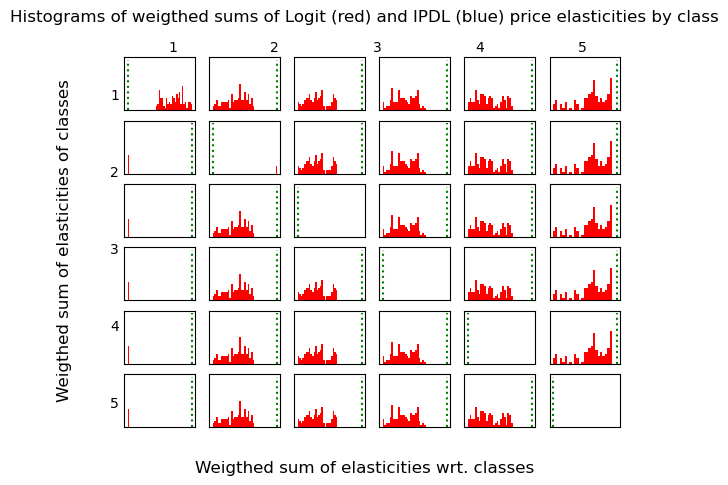

In [436]:
E0p = {j : (E0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(E0p[j], num_bins, range = (np.quantile(E0p[j], 0.10), np.quantile(E0p[j], 0.90)), color = 'r', alpha = 1) # Logit is blue
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of weigthed sums of Logit (red) and IPDL (blue) price elasticities by class')
fig.supxlabel('Weigthed sum of elasticities wrt. classes')
fig.supylabel('Weigthed sum of elasticities of classes')
fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

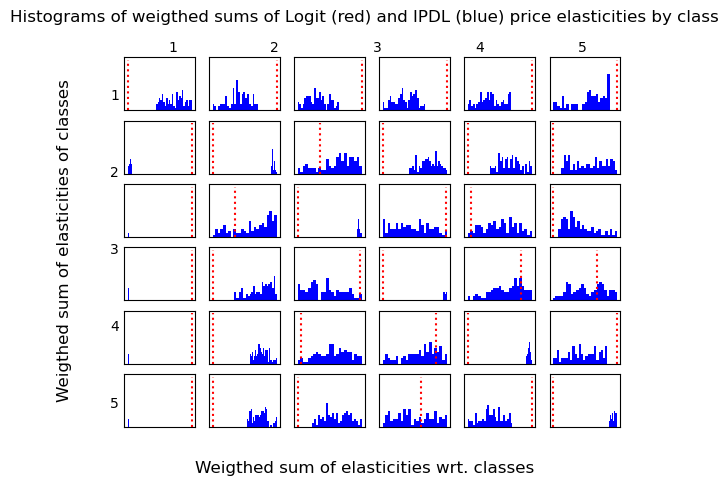

In [437]:
E1p = {j : (E1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig1, axes1 = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes1[p].hist(E1p[j], num_bins, range = (np.quantile(E1p[j], 0.10), np.quantile(E1p[j], 0.90)), color = 'b', alpha = 1) # IPDL is blue
    axes1[p].vlines(0, 0, 25, 'red', 'dotted')
    axes1[p].get_xaxis().set_visible(False)
    axes1[p].get_yaxis().set_visible(False)

fig1.suptitle('Histograms of weigthed sums of Logit (red) and IPDL (blue) price elasticities by class')
fig1.supxlabel('Weigthed sum of elasticities wrt. classes')
fig1.supylabel('Weigthed sum of elasticities of classes')
fig1.text(0.11, 0.8, '1', ha = 'center', va = 'center')
fig1.text(0.11, 0.64, '2', ha = 'center', va = 'center')
fig1.text(0.11, 0.48, '3', ha = 'center', va = 'center')
fig1.text(0.11, 0.32, '4', ha = 'center', va = 'center')
fig1.text(0.11, 0.16, '5', ha = 'center', va = 'center')
fig1.text(0.2, 0.9, '1', ha = 'center', va = 'center')
fig1.text(0.36, 0.9, '2', ha = 'center', va = 'center')
fig1.text(0.52, 0.9, '3', ha = 'center', va = 'center')
fig1.text(0.68, 0.9, '4', ha = 'center', va = 'center')
fig1.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### The mean elasticities for the logit model are given as...

In [438]:
pd.DataFrame(E0.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. product', index = 'Mean elasticity of product')

Mean elasticity wrt. product,0,1,2,3,4,5
Mean elasticity of product,,,,,,
0,0.021136,-0.010383,-0.004983,-0.003375,-0.001647,-0.000749
1,-0.775655,0.786409,-0.004983,-0.003375,-0.001647,-0.000749
2,-0.775655,-0.010383,0.791808,-0.003375,-0.001647,-0.000749
3,-0.775655,-0.010383,-0.004983,0.793416,-0.001647,-0.000749
4,-0.775655,-0.010383,-0.004983,-0.003375,0.795145,-0.000749
5,-0.775655,-0.010383,-0.004983,-0.003375,-0.001647,0.796043


#### For IPDL the mean elasticities are...

In [439]:
pd.DataFrame(E1.mean(axis = 0)).rename_axis(columns = 'Mean elasticity wrt. product', index = 'Mean elasticity of product')

Mean elasticity wrt. product,0,1,2,3,4,5
Mean elasticity of product,,,,,,
0,0.021379,-0.008483,-0.005694,-0.004078,-0.002152,-0.000970
1,-0.815071,0.779320,0.007760,0.014157,0.009460,0.004374
2,-0.780338,0.012001,0.773234,-0.013015,0.004899,0.003218
3,-0.780047,0.027293,-0.017304,0.777230,-0.005001,-0.002170
4,-0.779764,0.033687,0.012474,-0.009470,0.768247,-0.025174
5,-0.782954,0.037209,0.020711,-0.006422,-0.061080,0.792535


### Diversion ratios

We now visualize the implied diversion ratios $\mathcal{D}$. If $\bar D_{c\ell}$ denotes the sum of choice probability weigthed diversion ratios, then we have as above that $\bar D_{c\ell} = \sum_{j}\sum_{k} \mathrm{1}_{\{j\in c\}} \mathrm{1}_{\{k\in \ell\}} q_j q_k \mathcal{D}_{jk}$ i.e. more generally $\bar D = (\psi^{\text{class}} \circ q) \mathcal{D} (\psi^{\text{class}} \circ q).'$

In [440]:
Logit_D_agg = {t: -100*np.einsum('c,cl->cl', 1./np.diag(dq_dp_Logit_agg[t]), dq_dp_Logit_agg[t]) for t in np.arange(T)}
IPDL_D_agg = {t: -100*np.einsum('c,cl->cl', 1./np.diag(dq_dp_IPDL_agg[t]), dq_dp_IPDL_agg[t]) for t in np.arange(T)}

D0, D1 = np.empty((T, T_agg, T_agg)), np.empty((T, T_agg, T_agg))
for t in np.arange(T):
    D0[t,:,:] = Logit_D_agg[t]
    D1[t,:,:] = IPDL_D_agg[t]

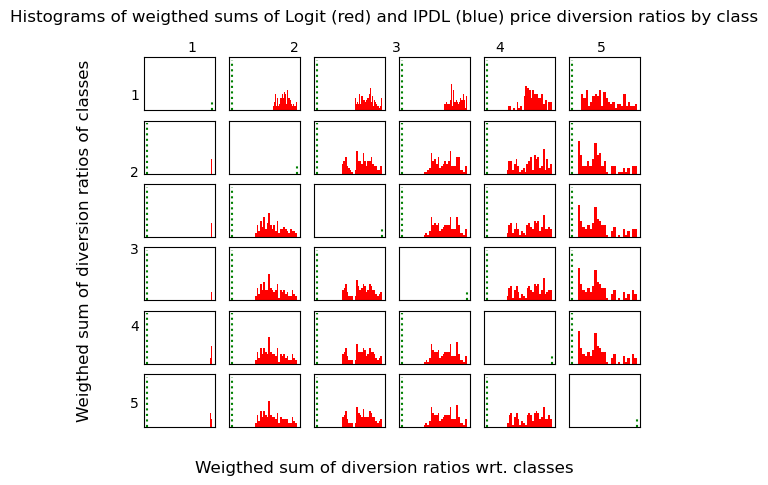

In [441]:
D0p = {j : (D0.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D0p[j], num_bins, range = (np.quantile(D0p[j], 0.10), np.quantile(D0p[j], 0.90)), color = 'r', alpha = 1) # Logit is red
    axes[p].vlines(0, 0, 25, 'g', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of weigthed sums of Logit (red) and IPDL (blue) price diversion ratios by class')
fig.supxlabel('Weigthed sum of diversion ratios wrt. classes')
fig.supylabel('Weigthed sum of diversion ratios of classes')
fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

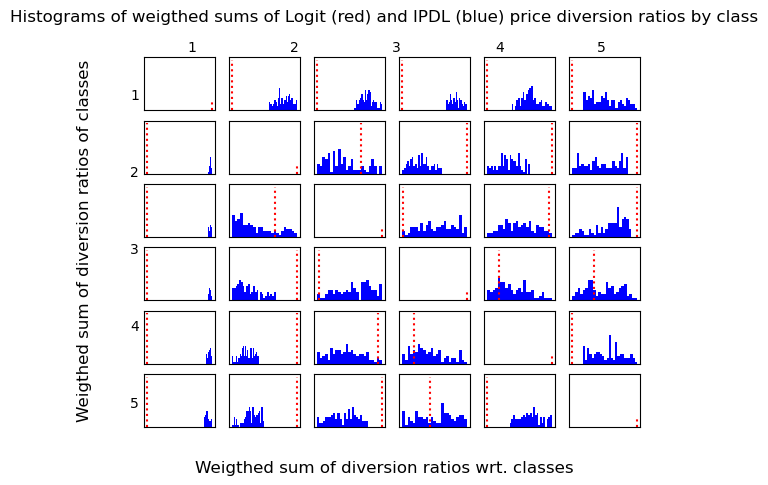

In [442]:
D1p = {j : (D1.reshape((T, T_agg**2))[:,j]).flatten() for j in np.arange(T_agg**2)}

j_pairs = iter.product(np.arange(T_agg), np.arange(T_agg))
num_bins = 25

fig, axes = plt.subplots(T_agg, T_agg, sharex=False, sharey=False)

for p, j in zip(j_pairs, np.arange(T_agg**2)):
    axes[p].hist(D1p[j], num_bins, range = (np.quantile(D1p[j], 0.10), np.quantile(D1p[j], 0.90)), color = 'b', alpha = 1) # IPDL is blue
    axes[p].vlines(0, 0, 25, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Histograms of weigthed sums of Logit (red) and IPDL (blue) price diversion ratios by class')
fig.supxlabel('Weigthed sum of diversion ratios wrt. classes')
fig.supylabel('Weigthed sum of diversion ratios of classes')
fig.text(0.11, 0.8, '1', ha = 'center', va = 'center')
fig.text(0.11, 0.64, '2', ha = 'center', va = 'center')
fig.text(0.11, 0.48, '3', ha = 'center', va = 'center')
fig.text(0.11, 0.32, '4', ha = 'center', va = 'center')
fig.text(0.11, 0.16, '5', ha = 'center', va = 'center')
fig.text(0.2, 0.9, '1', ha = 'center', va = 'center')
fig.text(0.36, 0.9, '2', ha = 'center', va = 'center')
fig.text(0.52, 0.9, '3', ha = 'center', va = 'center')
fig.text(0.68, 0.9, '4', ha = 'center', va = 'center')
fig.text(0.84, 0.9, '5', ha = 'center', va = 'center')

plt.show()

#### We also calculate the mean diversion ratios within each class. For the Logit model these are given as...

In [443]:
pd.DataFrame(D0.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. product', index = 'Mean diversion ratio of product')

Mean diversion ratio wrt. product,0,1,2,3,4,5
Mean diversion ratio of product,,,,,,
0,-100.000000,48.782097,23.849507,15.971722,7.977454,3.419220
1,98.631311,-100.000000,0.634197,0.429712,0.209490,0.095290
2,97.959027,1.311828,-100.000000,0.426505,0.208053,0.094587
3,97.760639,1.309103,0.628249,-100.000000,0.207616,0.094393
4,97.548601,1.305885,0.626770,0.424587,-100.000000,0.094157
5,97.438612,1.304417,0.626022,0.424078,0.206871,-100.000000


#### For the IPDL model the mean diversion ratios are...

In [444]:
pd.DataFrame(D1.mean(axis = 0)).rename_axis(columns = 'Mean diversion ratio wrt. product', index = 'Mean diversion ratio of product')

Mean diversion ratio wrt. product,0,1,2,3,4,5
Mean diversion ratio of product,,,,,,
0,-100.000000,39.496052,26.881012,18.974514,10.264926,4.383496
1,104.652976,-100.000000,-1.045935,-1.829014,-1.213758,-0.564269
2,100.986074,-1.612356,-100.000000,1.674446,-0.631465,-0.416699
3,100.413461,-3.531402,2.205802,-100.000000,0.630756,0.281384
4,101.625198,-4.387740,-1.654001,1.186493,-100.000000,3.230050
5,99.012551,-4.713950,-2.638694,0.727219,7.612874,-100.000000


## FKN estimation algorithm

The FKN estimator begins with a nonparametric estimate of the CCP function, yielding choice probabilities $\hat q^0_i$ for $i=1,\ldots,N$. We wish to find parameters such that the PUM first-order condition is approximately satisfied at $\hat q^0_i$, i.e. $\hat \theta^0$ such that 
$$
\hat q_i^0\approx P(X_i,\hat \theta^0),
$$
approximately over the sample. We introduce a residual,
$$
\hat \varepsilon^0_i(\theta)=\hat D^0_i(u(X_i,\beta)- \nabla_q \Omega(\hat q_i^0|\lambda)),
$$
where $\hat D^0_i=\textrm{diag}(\hat q^0_i)-\hat q^0_i (\hat q^0_i)'$. We have already seen that we can write
$$
u(X_i,\beta)-\nabla_q \Omega(\hat q_i^0|\lambda)=\hat G^0_i \theta-\ln \hat q^0_i
$$
where $\hat G^0_i=[X_i,\hat Z_i^0]$, where $Z_i^0 = \nabla_{q,\lambda}\Omega(q_i^0|\lambda)$. Letting $\hat A^0_i=\hat D^0_i \hat G^0_i$ and $\hat r_i^0=\hat D^0_i \ln \hat q^0_i$, we therefore have
$$
\hat \varepsilon^0_i(\theta)=\hat A^0_i\theta-\hat r^0_i.
$$
We minimize the weigthed mean of these residuals over $\theta$, with weights $\hat W^0_i=\textrm{diag}(\hat q^0_i)^{-1}$,

$$
\hat \theta^0 =\arg \min_{\theta} \frac{1}{N}\sum_i \hat \varepsilon_i(\theta)'\hat W_i^0 \hat \varepsilon_i(\theta)
$$
which has the closed-form solution
$$
\hat \theta^0 =\left(\frac{1}{N}\sum_i  (\hat A^0_i)'\hat W^0_i \hat A^0_i \right)^{-1}\left(\frac{1}{N}\sum_i  (\hat A^0_i)'\hat W^0_i \hat r_i^0 \right)
$$


In [445]:
def G_array(q, x, psi_stack, nest_count):
    ''' 
    This function calculates the G block matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        G: a dictionary  of T numpy arrays (J[t],K+G): a G matrix for each market t
    '''
    T = len(x)

    Z = cross_grad_pertubation(q, psi_stack, nest_count) # Find the cross derivative of the pertubation function \Omega wrt. lambda and ccp's q
    G = {t: np.concatenate((x[t],Z[t]), axis=1) for t in np.arange(T)} # Join block matrices along 2nd dimensions  s.t. last dimension is K+G (same dimension as theta)

    return G

In [446]:
def D_array(q):
    '''
    This function calculates the D matrix - the logit derivative of ccp's wrt. utilities

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t

    Returns
        D: a dictionary of T numpy arrays (J[t],J[t]) of logit derivatives of ccp's wrt. utilities for each market t
    '''
    T = len(q)

    D = {t: np.diag(q[t]) - np.einsum('j,k->jk', q[t], q[t]) for t in np.arange(T)}
    
    return D

In [447]:
def A_array(q, x, psi_stack, nest_count):
    '''
    This function calculates the A matrix

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        A: a dictionary  of T numpy arrays (J[t],K+G): an A matrix for each market t
    '''
    T = len(x)

    D = D_array(q)
    G = G_array(q, x, psi_stack, nest_count)
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)}

    return A

In [448]:
def r_array(q):
    '''
    This function calculates 'r'; the logarithm of observed or nonparametrically estimated market shares

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
    
    Returns
        r: a dictionary of T numpy arrays (J[t],) of the log of ccp's for each market t
    '''
    T = len(q)

    D = D_array(q) 
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where = (q[t] > 0)) for t in np.arange(T)}
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) for t in np.arange(T)}

    return r

In [449]:
def WLS_init(q, x, sample_share, psi_stack, nest_count, N):
    ''' 
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the initial FKN parameter estimates.

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        N: An integer giving the total amount of observations

    Returns
        theta_hat: a (K+G,) numpy array of initial FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for initial FKN parameter estimates
    '''

    T = len(x)

    W = {t: la.inv(np.diag(q[t])) for t in np.arange(T)}
    A = A_array(q, x, psi_stack, nest_count)
    r = r_array(q)

    d = A[0].shape[1]
    
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,jk,kp->dp', A[t], W[t], A[t], optimize = True)
        AWr[t,:] = sample_share[t]*np.einsum('jd,jk,k->d', A[t], W[t], r[t], optimize = True)
    
    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0))
    se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)
    
    return theta_hat,se_hat
    

Using the observed market shares we may thus find initial parameter estimates $\hat \theta^0$ as described above.

In [450]:
thetaFKN0,seFKN0 = WLS_init(y, x, pop_share, Psi_stack, Nest_count, N)

In [451]:
thetaFKN0[K:]

array([ 0.97014652, -0.00224835, -0.00600991, -0.00209521, -0.01570851,
        0.00361645,  0.00822438, -0.01589948,  0.00603873,  0.00388372,
       -0.05416584,  0.03497509])

In [452]:
seFKN0

array([5.01609511e-03, 2.83903623e-03, 3.05584179e-03, 2.61930605e-03,
       2.70621047e-03, 4.89192680e-03, 4.34925968e-03, 1.76902754e-03,
       3.54249018e-03, 1.55615617e-03, 1.37569616e-03, 2.80281150e-04,
       4.38670856e-03, 2.68958759e-04, 7.49329391e-04, 4.16962021e-04,
       3.56686104e-04, 1.75785191e-03, 2.14604945e-03, 2.67876857e-03,
       3.30346413e-04, 9.07330557e-04, 1.65228575e-03, 1.69593153e-03,
       3.22369097e-03, 5.62604136e-04, 7.97203752e-04, 4.55376137e-04,
       1.30665579e-03, 6.82737992e-04, 3.05693876e-04, 2.97750813e-04,
       3.80599098e-04, 1.48035566e-03, 7.71677490e-04, 3.99755904e-02,
       1.51722882e-03, 1.66228119e-02, 3.06088124e-03, 1.03886279e-03,
       1.50217279e-02, 6.90271009e-04, 7.63022104e-04, 7.26195759e-04,
       2.66804774e-04, 6.88537697e-05, 7.77830555e-05, 6.65060548e-05,
       7.48444627e-05, 8.21801290e-05, 5.63144061e-05, 5.16297734e-05,
       6.94100888e-05, 7.59488137e-05, 2.50698448e-04, 1.78502767e-04])

## Regularization for parameter bounds

As we see above, the least squares estimator is not guaranteed to respect the parameter bounds $\sum_g \hat \lambda_g<1$. However, we know that the logit probabilities $\hat q^{logit}_i$ returns the estimates $\hat \theta^{logit}=(\hat \beta^{logit},0,0)'$. We can construct a sequence of estimators using the mixture probabilities
$$
\hat q^{(t)}_i =(1-\alpha_t) \hat q^{logit}_i+\alpha_t \hat q_i
$$
and we know that $\hat q^{(t)}_i$ respects the parameter bounds for $\alpha_t$ sufficiently close to zero by continuity. We can then compare the likelihood values of each $\hat \theta^{(t)}$ and pick the best one. This ensures that the likelihood value of the initial estimator is at least as good as the logit solution. 

Note that the benefit of doing this is that we only ever need to do a one-dimensional grid search on the interval $[0,1]$ which is very simple. 
$$
\hat \theta^*=\arg \max_{t} \mathcal L_N(\hat \theta^{(t)})
$$


In [453]:
def LogL(Theta, y, x, sample_share, psi_stack, nest_count):
    ''' A function giving the mean IPDL loglikehood evaluated at data and an array of parameters 'Theta'
    '''
    return np.mean(IPDL_loglikelihood(Theta, y, x, sample_share, psi_stack, nest_count))

In [454]:
def GridSearch(Theta0, Logit_Beta, y, x, sample_share, psi_stack, nest_count, N, num_alpha = 5):
    ''' 
    '''
    T = len(x)
    d = Theta0.shape[0]
    K = x[0].shape[1]
    G = d-K

    # Find probabilities
    q_logit = logit.logit_ccp(Logit_Beta, x)
    q_obs = y

    # Search
    alpha_line = np.linspace(0, 1, num_alpha)
    LogL_alpha = np.empty((num_alpha,))
    theta_alpha = np.empty((num_alpha, d))

    for k in np.arange(num_alpha):

        alpha = alpha_line[k]

        if alpha == 0:
            theta_alpha[k,:] = np.concatenate((Logit_Beta, np.zeros((G,))))
        else:
            q_alpha = {t: (1 - alpha)*q_logit[t] + alpha*q_obs[t] for t in np.arange(T)}
            theta_alpha[k,:] = WLS_init(q_alpha, x, sample_share, psi_stack, nest_count, N)[0]

        lambda_alpha = theta_alpha[k,K:]
        
        pos_pars = np.array([theta for theta in lambda_alpha if theta > 0])

        if pos_pars.sum() > 0.999:
            LogL_alpha[k] = np.NINF
        else:
            LogL_alpha[k] = LogL(theta_alpha[k,:], y, x, sample_share, psi_stack, nest_count)
    
    # Pick the best set of parameters
    best_index = np.argmax(LogL_alpha)
    best_alpha = alpha_line[best_index]
    theta_hat_star = theta_alpha[best_index,:]

    return theta_hat_star,best_alpha

Implementing the grid search method we find corressponding parameters $\hat \theta^*$.

In [455]:
theta_hat_star = GridSearch(thetaFKN0, logit_beta, y, x, pop_share, Psi_stack, Nest_count, N)[0]

0.0
0.583821646614179


0.8492343145984843
0.9513572188815023


In [456]:
theta_hat_star[K:]

array([ 7.81168466e-01,  7.08167229e-04, -8.03213491e-04, -9.16587615e-03,
       -8.23486772e-03,  1.63695727e-03,  9.73097846e-03, -4.70500605e-03,
        6.55987886e-03,  2.99059446e-03,  1.60510041e-02,  3.03882687e-02])

## Iterated FKN estimator

The iterated estimator is as the initial one, except there is an additional term on $\hat \varepsilon$. First, we update the choice probabilities,
$$
\hat q^k_i=p(\mathbf X_i,\hat \theta^{k-1})\\
$$
Then we assign
$$
\hat D^k_i=\nabla^2_{qq}\Omega(\hat q_i^k|\hat \lambda^{k-1})^{-1}-(\hat q^k_i \hat q^k_i)'
$$
and then construct the residual
$$
\hat \varepsilon^k_i(\theta)=\hat D^k_i\left( u(x_i,\beta)-\nabla_q \Omega(\hat q_i^k|\lambda)\right) -y_i+\hat q_i^k,
$$
Which can once again be simplified as
$$
\hat \varepsilon^k_i(\theta)= \hat A_i^k \theta-\hat r^k_i,
$$
where
$$
\hat A^k_i=\hat D_i^k\hat G^k_i, \hat r_i^k =\hat D^k_i\ln \hat q_i^k-y_i
$$
and where $\hat G^k_i$ is constructed as in the initial estimator. Using the weighted least squares estimator with weights $\hat W_i^k=\textrm{diag}(\hat q^k_i)^{-1}$, we get the estimator
$$
\hat \theta^k = \arg \min_{\theta}\frac{1}{n}\sum_i \hat \varepsilon^k_i(\theta)'\hat W_i^k \hat \varepsilon^k_i(\theta).
$$
We can once again solve it in closed form as
$$
\hat \theta^k =\left( \frac{1}{n}\sum_i \hat (A^k_i)'\hat W_i^k \hat A^k_i)\right)^{-1}\left( \frac{1}{n}\sum_i (\hat A_i^k)'\hat W_i^k \hat r_i^k\right)
$$
Now we implement this procedure and iterate starting from our initial guess $\hat \theta^{*}$


In [457]:
def WLS(Theta, y, x, sample_share, psi_stack, nest_count, N):
    '''
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error for the iterated parameter estimates.

    Args.
        q: a dictionary of T numpy arrays (J[t],) of choice probabilities for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t
        N: An integer giving the total amount of observations

    Returns
        theta_hat: a (K+G,) numpy array of initial FKN parameter estimates
        se_hat: a (K+G,) numpy array of standard errors for initial FKN parameter estimates
    '''
    T = len(x)
    d = Theta.shape[0]
    
    # Get ccp's
    q = IPDL_ccp(Theta, x, psi_stack, nest_count)

    # Construct A
    D = ccp_gradient(q, x, Theta, psi_stack, nest_count) # A is here constructed using the IPDL derivative of ccp's wrt. utilities instead of teh Logit derivative
    G = G_array(q, x, psi_stack, nest_count)
    A = {t: np.einsum('jk,kd->jd', D[t], G[t]) for t in np.arange(T)}
    W = {t: la.inv(np.diag(q[t])) for t in np.arange(T)}

    # Construct r
    log_q = {t: np.log(q[t], out = -np.inf*np.ones_like(q[t]), where=(q[t] > 0)) for t in np.arange(T)}
    r = {t: np.einsum('jk,k->j', D[t], log_q[t]) + y[t] for t in np.arange(T)}

    # Estimate parameters
    AWA = np.empty((T,d,d))
    AWr = np.empty((T,d))

    for t in np.arange(T):
        AWA[t,:,:] = sample_share[t]*np.einsum('jd,jk,kp->dp', A[t], W[t], A[t], optimize = True)
        AWr[t,:] = sample_share[t]*np.einsum('jd,jk,k->d', A[t], W[t], r[t], optimize = True)

    theta_hat = la.solve(AWA.sum(axis = 0), AWr.sum(axis = 0))
    se_hat = np.sqrt(np.diag(la.inv(AWA.sum(axis = 0))) / N)

    return theta_hat,se_hat

In [458]:
def FKN_estimator(logit_beta, q_obs, x, sample_share, psi_stack, nest_count, N, tol = 1.0e-15, max_iters = 1000):
    ''' 
    '''

    theta_init = WLS_init(q_obs, x, sample_share, psi_stack, nest_count,  N)[0]
    theta_hat_star = GridSearch(theta_init, logit_beta, y, x, sample_share, psi_stack, nest_count, N)[0]
    theta0 = theta_hat_star
    
    for k in np.arange(max_iters):
        theta1, se1 = WLS(theta0, q_obs, x, sample_share, psi_stack, nest_count, N)

        # Check convergence in an appropriate distance function
        dist = np.max(np.abs(theta1 - theta0))

        if dist<tol:
            succes = True
            iter = k
            break
        elif k==max_iters:
            succes = False
            iter = max_iters
            break
        else:
            None
            
        # Iteration step
        theta0 = theta1

    res = {'theta': theta1,
           'se': se1,
           'fun': -LogL(theta1, y, x, sample_share, psi_stack, nest_count),
           'iter': iter,
           'succes': succes}
    
    return res 
        

In [459]:
res = FKN_estimator(logit_beta, y, x, pop_share, Psi_stack, Nest_count, N, tol=1.0e-8, max_iters=1000)

0.0
0.583821646614179
0.8492343145984843
0.9513572188815023
0.7934622460204379


In [460]:
FKN_theta = res['theta']

In [461]:
q_IPDL(FKN_theta, y, x, pop_share, Psi_stack, Nest_count).mean()

0.7934622460204379


0.0014935862052751073

# BLP Estimation and instruments

The setting is now a bit different. Instead of the noise coming from random sampling of individuals, we now have an additional source of uncertainty, stemming frm the random sampling of the fixed effects ξmj for each market and each product. The number of ”observations” is therefore

$$
T = M \cdot \sum_m J_m
$$

Note that while random sampling of individuals choices (number of observations
in the hundreds of millions) still has an effect on the estimated parameters in
principle, this effect is completely drowned out by the sampling variance of the
fixed effects (number of observations T ≈ 15000?), so we choose to ignore it
here. When estimating random coefficients models, there is also a third source
of uncertainty stemming from approximation of numerical integrals. This is not
an issue in IPDL, as we have the inverse demand in closed form.

The principles are pretty similar to what we have been doing already. When
applicable, I will use the same notation as in the FKN section. Define the
residual,

$$\xi_m(\theta) = u(X_m, \beta) − \nabla_q \Omega(q^0|\lambda)$$

In the IPDL model, this residual is a linear function of $\theta$ which has the form

$$\xi_m(\theta) =  G^0_m \theta − r_m^0$$

where $ G^0_m=[X_m, Z_m^0]$, where $Z_m^0 = \nabla_{q,\lambda}\Omega(q_m^0|\lambda)$ and $r^0_m = \ln q^0_m$ as in the FKN section with $q^0_m$ being e.g. the observed market shares in market $m$. For the BLP estimator, we set this residual orthogonal to a matrix of instruments $\hat Z_m$ of size $J_m \times d$, and find the estimator $ \hat \theta^{IV}$ which solves the moment conditions

$$\frac{1}{T} \sum_m \hat Z_m' \xi(\hat \theta^{IV}) = 0$$

Since $\hat \xi$ is linear, the moment equations have a unique solution,

$$\hat \theta^{IV} = \left(\frac{1}{T}\sum_m \hat Z_m' G^0_m \right)^{-1}\left(\frac{1}{T}\sum_m \hat Z_m' r^0_m \right)$$

We require an instrument for the price of the goods. This is something which is correlated with the price, but uncorrelated with the error term $\xi_m$ (in the BLP model, $\xi_{mj}$ represents unobserved components of car quality). A standard instrument in this case would be a measure of marginal cost (or something which is correlated with marginal cost, like a production price index). For everything other than price, we can simply use the regressor itself as the instrument i.e. $ \hat Z^{mjd} = G^0_{mjd}$, for all other dimensions than price.

First we construct our instruments $\hat Z$. We'll use the average exchange rate of the destination country relative to average exchange rate of the origin country. 

In [462]:
xexr = {t: dat[dat['market'] == t]['xexr'].values for t in np.arange(T)}
G0 = G_array(y, x, Psi_stack, Nest_count)
pr_index = len(x_contvars)
for t in np.arange(T):
    G0[t][:,pr_index] = xexr[t] / xexr[t].max()

z = G0

We then calculate the moment estimator $\hat \theta^{IV}$.

In [463]:
def BLP_estimator(y, z, x, sample_share, psi_stack, nest_count):
    '''
    Args.
        y: a dictionary of T numpy arrasy (J[t],) of observed or nonparametrically estimated market shares for each market t
        z: a dictionary of T numpy arrays (J[t],K+G) of instruments for each market t
        x: a dictionary of T numpy arrays (J[t],K) of covariates for each market t
        sample_share: A (T,) numpy array of the fraction of observations in each market t 
        psi_stack: a dictionary of T numpy arrays (J[t] + sum(C_g),J[t]) of the J[t] by J[t] identity stacked on top of the \psi^g matrices for each market t as outputted by 'Create_nests'
        nest_count: a dictionary of T numpy arrays (G,) containing the amount of nests in each category g in each market t

    Returns
        theta_hat: a numpy array (K+G,) of BLP parameter estimates
    '''
    T = len(z)

    G = G_array(y, x, psi_stack, nest_count)
    d = G[0].shape[1]
    r = {t: np.log(y[t], out = np.NINF*np.ones_like((y[t])), where = (y[t] > 0)) for t in np.arange(T)}
    
    sZG = np.empty((T,d,d))
    sZr = np.empty((T,d))

    for t in np.arange(T):
        sZG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', z[t], G[t])
        sZr[t,:] = sample_share[t]*np.einsum('jd,j->d', z[t], r[t])

    theta_hat = la.solve(sZG.sum(axis=0), sZr.sum(axis=0))
    
    return theta_hat

In [464]:
BLP_theta = BLP_estimator(y, z, x, np.ones((T,)), Psi_stack, Nest_count)

In [465]:
np.array([p for p in BLP_theta[K:] if p>0]).sum()

1.0488350724635895

In the Logit model we get the parameter estimates:

In [466]:
G_logit = x
for t in np.arange(T):
    G_logit[t][:,pr_index] = xexr[t] / xexr[t].max()

z_logit = G_logit

In [467]:
LogitBLP_beta = logit.LogitBLP_estimator(y, z_logit, x, np.ones((T,)))

In [468]:
LogitBLP_beta

array([-14.41280532,  -3.40334572,  -6.89531188,  -0.20128066,
        -1.64085748,   9.70660596,  -1.33834143,  -0.35656005,
         5.5599548 ,   0.04321336,  -0.20332981,   1.55202333,
        -1.41808955,  -0.09416481,  -0.90156117,  -0.42922998,
        -0.53882082,  -1.07436156,  -0.34372782,  -2.15059897,
        -0.4392745 ,  -0.39547664,  -1.40645645,  -2.3489272 ,
        -2.21275414,  -1.44546677,  -1.13740087,   1.00080306,
        -1.30906969,  -0.15365879,  -0.24497036,  -0.14472295,
        -0.78562084,  -0.48042182,  -1.21026099,  -2.98856691,
        -0.81187713,  -2.72286568,  -1.53059041,  -0.14984331,
        -1.31045303,  -0.91588229,  -0.52693591,   0.09731265])

### BLP approximation to optimal instruments

BLP propose an algorithm for constructing an approximation to the optimal instruments. It is described in simple terms in Reynaert & Verboven (2014), and it has the following steps.
It requires an initial parameter estimator $\hat \theta = (\hat \beta', \hat \lambda')'$, here we can just usethe MLE we have already computed. Let $W_m$ denote the matrix of instruments (this is the matrix $X_m$ with the price replaced by the exchange rate). The steps are then as follows:

First we form the regression equation of the covariates on the instruments:
$$
X_m = W_m \Pi + E_m
$$

The OLS estimate is then given as:
$$
\hat \Pi = \left( \frac{1}{T}\sum_m W_m' W_m \right)^{-1}\left( \frac{1}{T}\sum_m W_m' X_m\right)
$$

Thus the predicted covariates given the instruments $W$ are:
$$
\hat X_m = W_m \hat \Pi
$$

Having constructed $\hat X_m$ (which consists of the exogenous regressors, and the predicted price given $W_m$), we compute the predicted mean utility:

$$
\hat u_m = \hat X_m \hat \beta
$$

and then the predicted market shares at the mean utility:

$$
\hat q_m^{*} = P(\hat u_m | \hat \lambda)
$$

Computationally, here we just use $\hat X_m$ in place of $X_m$ in the CCP function.
Given the predicted market shares, we compute

$$
\hat G_m^{*} = \left[\hat X_m, \nabla_{q,\lambda} \Omega (\hat q_m^{*} | \hat \lambda)\right]
$$

which is the same as the function $\hat G_m^0$ we already have constructed, except we evaluate it at the
predictions $\hat X_m$ and $\hat q_m^{*}$ instead of at $X_m$ and $\hat q_m^0$.

The procedure above gives an approximation to the optimal instruments. We also require a weight matrix. The optimal weight matrix is the (generalized) inverse of the conditional (on the instruments) covariance of the fixed effects. Assuming $\xi_{jm}$ is independetly and identically distributed over j and m, the conditional covariance simplifies to a scalar $\sigma^2$ times an identity matrix (of size $J_m$).
This means that all fixed effects are weighted equally, and the weights therefore drop out of the IV regression. The optimal IV estimator is therefore

$$
\hat \theta^{\text{IV}} = \left(\frac{1}{T}\sum_m (\hat G_m^*)'\hat G_m^0\right)^{-1}\left( \frac{1}{T}\sum_m (\hat G_m^*)'\hat r_m^0 \right)
$$

Let $\hat \xi^*$ denote the estimated residual evaluated at the new parameter estimates,

$$
\hat \xi_{mj}^* = \hat \xi_{mj}(\hat \theta^{\text{IV}})
$$

We may estimate the constant $\sigma^2$ by

$$
\hat \sigma^2 = \frac{1}{T}\sum_{m}\sum_{j = 1}^{J_m} \left(\hat \xi_{mj}^*\right)^2 
$$

The distribution of the estimator $\hat \theta^{\text{IV}}$ is then

$$
\hat \theta^{\text{IV}} \sim \mathcal{N}(\theta_0, \Sigma^{\text{IV}})
$$

which can be consistently estimated by

$$
\hat \Sigma^{\text{IV}} = \hat \sigma^2 \left( \sum_m (\hat G_m^*)'\hat G_m^0 \right)^{-1}
$$

and the standard errors are then the square root of the diagonal elements.

In [469]:
def predict_x(x, w, sample_share):
    ''' 
    '''
    T = len(w)
    K = w[0].shape[1]

    sWW = np.empty((T,K,K))
    sWX = np.empty((T,K,K))

    for t in np.arange(T):
        sWW[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], w[t])
        sWX[t,:,:] = sample_share[t]*np.einsum('jk,jl->kl', w[t], x[t])

    Pi_hat = la.solve(sWW.sum(axis=0), sWX.sum(axis=0))
    X_hat = {t: np.einsum('jl,lk->jk', w[t], Pi_hat) for t in np.arange(T)}

    return X_hat

In [470]:
def BLP_se(Theta, y, x, psi_stack, nest_count):
    ''' 
    '''
    T = len(x)
    S = T * np.array([x[t].shape[0] for t in np.arange(T)]).sum()

    G = G_array(y, x, psi_stack, nest_count)
    d = G[0].shape[1]
    r = {t: np.log(y[t]) for t in np.arange(T)}
    
    # We calculate \sigma^2
    xi = {t: np.einsum('jd,d->j', G[t], Theta) - r[t] for t in np.arange(T)}
    sum_xij2 = np.empty((T,))

    for t in np.arange(T):
        sum_xij2[t] = (xi[t]**2).sum()
    
    sigma2 = np.sum(sum_xij2) / S

    # We calculate GG for each market t
    GG = np.empty((T,d,d))

    for t in np.arange(T):
        GG[t,:,:] = np.einsum('jd,jp->dp', G[t], G[t])

    # Finally we compute \Sigma and the standard errors
    Sigma = sigma2*la.inv(GG.sum(axis=0))
    SE = np.sqrt(np.diag(Sigma))

    return SE

In [471]:
def OptimalBLP_estimator(Theta0, y, w, x, sample_share, psi_stack, nest_count):
    ''' 
    '''
    T = len(x)
    K = x[0].shape[1]

    beta0 = Theta0[:K]
    lambda0 = Theta0[K:]
    
    X_hat = predict_x(x, w, sample_share)
    q0 = IPDL_ccp(Theta0, X_hat, psi_stack, nest_count)
    G_star =G_array(q0, X_hat, psi_stack, nest_count)
    #G_star =G_array(y, w, psi_stack, nest_count)


    G0 = G_array(y, x, psi_stack, nest_count)
    
    #G_star=G0
    
    r = {t: np.log(y[t]) for t in np.arange(T)}

    d = G0[0].shape[1]

    sGG = np.empty((T,d,d))
    sGr = np.empty((T,d))

    for t in np.arange(T):
        sGG[t,:,:] = sample_share[t]*np.einsum('jd,jp->dp', G_star[t], G0[t])
        sGr[t,:] = sample_share[t]*np.einsum('jd,j->d', G_star[t], r[t])

    Theta_IV = la.solve(sGG.sum(axis=0), sGr.sum(axis=0))
    SE_IV = BLP_se(Theta_IV, y, x, psi_stack, nest_count)

    return Theta_IV, SE_IV

In [472]:
ThetaOptBLP, SEOptBLP = OptimalBLP_estimator(FKN_theta, y, z_logit, x, np.ones((T,)), Psi_stack, Nest_count)

In [474]:
G0 = G_array(y, x, Psi_stack, Nest_count)
d = G0[0].shape[1]
r = {t: np.log(y[t]) for t in np.arange(T)}

# We calculate \sigma^2
xi = {t: np.einsum('jd,d->j', G0[t], ThetaOptBLP) - r[t] for t in np.arange(T)}
xi_np = np.empty((np.int64(J.sum()),))
index = J.cumsum()
for t in np.arange(T):
    if t == 0:
        xi_np[:index[t]] = xi[t]
    else:
        xi_np[index[t-1]:index[t]] = xi[t]

xi_np -= xi_np.mean() 

In [475]:
xi_np.mean()

0.0

In [476]:
len(J)

150

In [477]:
np.array([p for p in ThetaOptBLP[K:]  if p > 0]).sum()

0.8776777375151663

In [478]:
ThetaOptBLP[K:]

array([ 5.28173042e-01, -3.15092898e-02,  3.44658661e-02, -2.08991905e-04,
        1.94108492e-02, -9.95648060e-03,  3.95530634e-02, -2.71591621e-03,
        7.28507623e-03,  4.97535967e-03, -4.47158701e-01,  2.43814481e-01])

In [488]:
nest_vars

['in_out',
 'cy',
 'hp',
 'we',
 'le',
 'wi',
 'he',
 'li',
 'sp',
 'ac',
 'home',
 'brand']

In [479]:
SEOptBLP[K:]

array([0.00145795, 0.00054185, 0.00059773, 0.00050376, 0.000536  ,
       0.00056075, 0.00041788, 0.00042156, 0.00051661, 0.00037735,
       0.00129173, 0.00098001])

In [480]:
S = T*np.array([x[t].shape[0] for t in np.arange(T)]).sum()
S

1402350

In [481]:
LogitBLP_beta[pr_index]

-0.2033298123789972

In [482]:
ThetaOptBLP[pr_index]

-0.16183510387832414

In [483]:
-LogL(ThetaOptBLP, y, x, pop_share, Psi_stack, Nest_count)

0.8776777375151663


0.0015060950839790848

In [484]:
la.norm(FKN_theta)

15.021697271544799

In [485]:
la.norm(BLP_theta)

7.496273124082977

In [486]:
la.norm(ThetaOptBLP)

16.49276478812854